In [1]:
import time
from importlib import reload
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
def calc_process_time(t0, verbose=False, leadspaces="", output=False, unit="min"):
    """
        Calculates the processing time/time difference for a given input time and the current time

    Usage:
        Process_t0 = time.time()
        #your process
        calc_process_time(Process_t0, verbose=True, leadspaces="  ")

        :param t0:              starting time stamp
        :param verbose:         verbose? True or False
        :param leadspaces:      pre-fix, e.g., some space in front of any verbose output
        :param output:          provide an output (s. below)? True or False
        :return: dt (optional)  the calculated processing time
    :rtype:
    """
    dt = time.time() - t0
    if verbose:
        if unit=="min":
            print(leadspaces + f'process time: {round(dt / 60, 2)} min')
        elif unit=="sec":
            print(leadspaces + f'process time: {round(dt , 10)} sec')
    if output:
        return dt
try:
    os.mkdir("plots")
except:
    pass
try:
    os.mkdir("plots/png")
except:
    pass

In [3]:
OS          = "macOS" # macOS Windows Linux
editor_n    = 3 # choose the editor# from the list below
venv_n      = 2 # choose venv form the list below
N_rep       = 10 # Number of repetitions
#                          0                    1               2         3
editor_list = ["VS Code (interactive)","VS Code (terminal)","PyCharm","Jupyter"]
#                  0       1          2
venv_list   = ["conda","python","virtualenv"]
editor      = editor_list[editor_n]
venv        = venv_list[venv_n]

In [4]:
times_imports = []
Process_t0 = time.time()
for rep in range(N_rep):
    if rep==0:
        import matplotlib.pyplot as plt
        import numpy as np
        import seaborn as sns
        import pandas as pd
        import zarr
        import plotly
        import plotly.express as px
        import plotly.io as pio
        from skimage import segmentation as seg
        from scipy import ndimage as ndi
        from skimage import feature
        from scipy import ndimage
        import timeit
    else:
        plt = reload(plt)
        np = reload(np)
        sns = reload(sns)
        pd = reload(pd)
        zarr = reload(zarr)
        plotly = reload(plotly)
        px = reload(px)
        pio = reload(pio)
        seg = reload(seg)
        ndi = reload(ndi)
        feature = reload(feature)
        ndimage = reload(ndimage)
        timeit = reload(timeit)
    Process_t1 = calc_process_time(Process_t0, leadspaces=f"{N_rep} reps of imports: ", 
                                output=True, unit="sec", verbose=False)
    times_imports.append(Process_t1)
times_imports = np.array(times_imports)
print(f"Average elapsed time for imports: {times_imports.mean()} s")

Average elapsed time for imports: 1.4344951391220093 s


In [5]:
zarr_out_root   = zarr.open('data.zarr', mode='a')
zarr_curr_group = zarr_out_root.create_group(OS + " " + editor + " " + venv, overwrite=True)
zarr_curr_group.attrs["OS"]     = OS
zarr_curr_group.attrs["editor"] = editor
zarr_curr_group.attrs["venv"]   = venv
zarr_curr_group.attrs["N_rep"]  = N_rep
# save the first results (import test)
_ = zarr_curr_group.create_dataset("import_test", data=times_imports,
                                   chunks=False, overwrite=True)

In [6]:
def plot_1D_series(times, y, y_err, figsize=(5,3.5), xlim=(0,1),ylim=(0,1),
                   xticks=np.arange(0,1),yticks=np.arange(0,1),title="",
                   test="", OS="", editor="", venv="", show_plot=False):
    plt.close(1)
    fig=plt.figure(1, figsize=figsize)
    fig.clf()
    plt.plot(times, y, label=editor+" ("+OS+")", lw=2, c="royalblue")
    plt.fill_between(times, y - y_err, y + y_err,
                    edgecolor="cornflowerblue", facecolor="cornflowerblue",
                    alpha=0.25, linewidth=0.0)
    plt.text(times[-1:], y[-1:], str(y[-1:].round(2)[0])+" s ⟶ ",
             ha="right", va="center", clip_on=False)
    plt.xlabel("N", fontsize=12, fontweight="bold")
    plt.ylabel("time [s]", fontsize=12, fontweight="bold")
    plt.title(title, fontweight="bold")
    plt.legend(loc="upper left")
    axis = plt.gca()
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.spines['bottom'].set_linewidth(2)
    axis.spines['left'].set_linewidth(2)
    axis.xaxis.set_tick_params(width=2, length=8)
    axis.yaxis.set_tick_params(width=2, length=8)
    plt.xlim(xlim)
    plt.xticks(xticks,fontsize=12)
    plt.ylim(ylim)
    plt.yticks(yticks,fontsize=12)
    plt.tight_layout()
    plt.savefig("plots/"+test+" "+OS+" "+venv+" "+editor+".pdf")
    plt.savefig("plots/png/"+test+" "+OS+" "+venv+" "+editor+".png", dpi=200)
    if show_plot:
        plt.show()

Average elapsed time for calculating exp(N) (N=0,..., 100000): 1.430511474609375e-06 s
Average cumulative elapsed time for calculating exp(N) (N=0,..., 100000): 0.1975574254989624 s


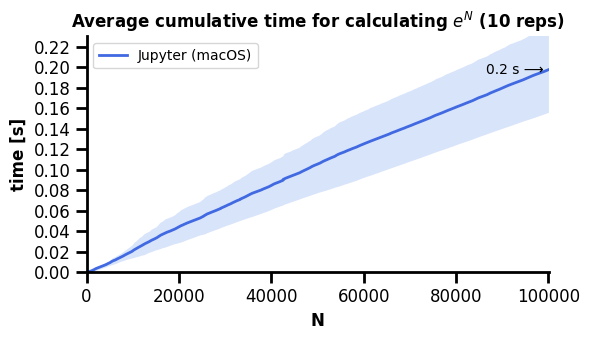

In [7]:
N=100000
times_exp = np.zeros((N_rep, 3,N), dtype="float64")
for rep in range(N_rep):
    times_exp_tmp = np.zeros((3,N), dtype="float64")
    for i in range(N):
        Process_t0 = time.time()
        dump = np.exp(i)
        del dump
        times_exp_tmp[0, i] = i
        times_exp_tmp[1,i] = calc_process_time(Process_t0, output=True, unit="sec")
        if i > 0:
            times_exp_tmp[2, i] = times_exp_tmp[2, i - 1] + times_exp_tmp[1, i]
    times_exp[rep,:,:] = times_exp_tmp
times_exp_mean = times_exp.mean(axis=0)
times_exp_std  = times_exp.std(axis=0)
print(f"Average elapsed time for calculating exp(N) (N=0,..., {N}): {times_exp_mean[1,-1:][0]} s")
print(f"Average cumulative elapsed time for calculating exp(N) (N=0,..., {N}): {times_exp_mean[2,-1:][0]} s")
zarr_out_exp = zarr_curr_group.create_dataset("exponential_test", data=times_exp, 
                                            chunks=False, overwrite=True)
zarr_out_exp.attrs["N"] = N

plot_1D_series(times=times_exp_mean[0, :], y=times_exp_mean[1, :],
               y_err=times_exp_std[1, :], figsize=(6,3.5), 
               xlim=(0,N+50), xticks=np.arange(0,N+1,20000), 
               ylim=(0,0.000250), yticks=np.arange(0,0.000251,0.000020),
               title=f"Average time for calculating $e^N$ ({N_rep} reps)",
               test="exponentiation", OS=OS, editor=editor, venv=venv)

plot_1D_series(times=times_exp_mean[0, :], y=times_exp_mean[2, :],
               y_err=times_exp_std[2, :], figsize=(6,3.5),
               xlim=(0,N+50), xticks=np.arange(0,N+1,20000),
               ylim=(0,0.23), yticks=np.arange(0,0.24,0.02),
               title=f"Average cumulative time for calculating $e^N$ ({N_rep} reps)",
               test="exponentiation (cumulative)", OS=OS, editor=editor, venv=venv)

Average cumulative elapsed time for allocating and transposing an 2000x2000 array: 10.831509947776794 s


' plot_1D_series(times=times_allocate_mean[0, :], y=times_allocate_mean[2, :], \n               y_err=times_allocate_std[2, :], figsize=(5,3.5), \n               xlim=(0,2050), xticks=np.arange(0,2001,250), \n               ylim=(0,13), yticks=np.arange(0,13,2),\n               title=f"Average cumulative time for allocating and\ntransposing an $N \\times N$ array ({N_rep} reps)",\n               test="transposing (cumulative)", OS=OS, editor=editor, show_plot=show_plot) '

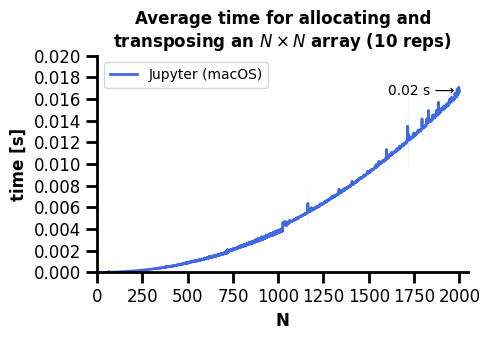

In [8]:
N=2000
times_allocate = np.zeros((N_rep,3,N), dtype="float64")
for rep in range(N_rep):
    times_allocate_tmp = np.zeros((3,N), dtype="float64")
    np.random.seed(1)
    for i in range(N):
        Process_t0 = time.time()
        dump = np.random.random((i,i))
        dump = np.transpose(dump)
        del dump
        times_allocate_tmp[0, i] = i
        times_allocate_tmp[1,i] = calc_process_time(Process_t0, output=True, unit="sec")
        if i>0:
            times_allocate_tmp[2, i] = times_allocate_tmp[2, i-1]+ times_allocate_tmp[1,i]
    times_allocate[rep,:, :] = times_allocate_tmp
times_allocate_mean = times_allocate.mean(axis=0)
times_allocate_std = times_allocate.std(axis=0)
print(f"Average cumulative elapsed time for allocating and transposing an {N}x{N} array: {times_allocate_mean[2,-1:][0]} s")
#print(f"total elapsed for N={N}: {times_allocate_mean[2,-1:]}")
#print(f"total elapsed for N={N}: {times_allocate[1,:].sum()}")
zarr_out_trans = zarr_curr_group.create_dataset("transpose_test", data=times_allocate, 
                                            chunks=False, overwrite=True)
zarr_out_trans.attrs["N"] = N

plot_1D_series(times=times_allocate_mean[0, :], y=times_allocate_mean[1, :], 
               y_err=times_allocate_std[1, :], figsize=(5,3.5), 
               xlim=(0,2050), xticks=np.arange(0,2001,250), 
               ylim=(0,0.020), yticks=np.arange(0,0.021,0.002),
               title=f"Average time for allocating and\ntransposing an $N \\times N$ array ({N_rep} reps)",
               test="transposing", OS=OS, editor=editor, venv=venv)

""" plot_1D_series(times=times_allocate_mean[0, :], y=times_allocate_mean[2, :], 
               y_err=times_allocate_std[2, :], figsize=(5,3.5), 
               xlim=(0,2050), xticks=np.arange(0,2001,250), 
               ylim=(0,13), yticks=np.arange(0,13,2),
               title=f"Average cumulative time for allocating and\ntransposing an $N \\times N$ array ({N_rep} reps)",
               test="transposing (cumulative)", OS=OS, editor=editor, show_plot=show_plot) """

Average cumulative elapsed time for SVD of an 500x500 array: 18.211211109161376 s


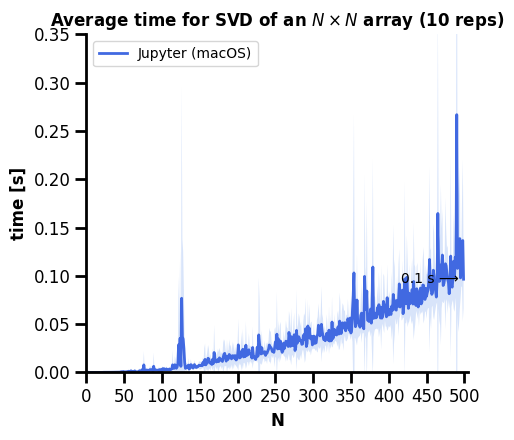

In [9]:
N=500
times_svd = np.zeros((N_rep,3,N), dtype="float64")
for rep in range(N_rep):
    times_svd_tmp = np.zeros((3,N), dtype="float64")
    np.random.seed(1)
    for i in range(2,N):
        Process_t0 = time.time()
        dump = np.random.uniform(size=(i,i))
        dump = np.linalg.svd(dump)
        del dump
        times_svd_tmp[0, i] = i
        times_svd_tmp[1,i] = calc_process_time(Process_t0, output=True, unit="sec")
        if i>0:
            times_svd_tmp[2, i] = times_svd_tmp[2, i-1]+ times_svd_tmp[1,i]
    times_svd[rep,:, :] = times_svd_tmp
times_svd_mean = times_svd.mean(axis=0)
times_svd_std = times_svd.std(axis=0)
print(f"Average cumulative elapsed time for SVD of an {N}x{N} array: {times_svd_mean[2,-1:][0]} s")
zarr_out_svd = zarr_curr_group.create_dataset("svd_test", data=times_svd, 
                                            chunks=False, overwrite=True)
zarr_out_svd.attrs["N"] = N

plot_1D_series(times=times_svd_mean[0, :], y=times_svd_mean[1, :], 
               y_err=times_svd_std[1, :], figsize=(5,4.5), 
               xlim=(0,N+5), xticks=np.arange(0,N+1,50), 
               ylim=(0,0.35), yticks=np.arange(0,0.36,0.05),
               title=f"Average time for SVD of an $N \\times N$ array ({N_rep} reps)",
               test="svd", OS=OS, editor=editor, venv=venv)